In [1]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from tia.bbg import LocalTerminal
from pandas.tseries.offsets import *
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import sklearn.mixture as mix
import statsmodels.api as sm
import networkx as nx
from pprint import pprint 

import numpy as np
import scipy.stats as scs

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns


In [2]:
# Getting BBG data and cleaning
StartDate = '1995-12-30'
EndDate = (dt.datetime.today()-BDay(1)).strftime("%m/%d/%Y")

Dates = pd.DataFrame(pd.date_range(StartDate,EndDate,freq="D"),columns=['Date'])
Dates = Dates.set_index('Date',drop=True)
Dates.index.name = None

Month = pd.DataFrame(pd.date_range(StartDate,EndDate,freq="M"),columns=['Date'])
Month = Month.set_index('Date',drop=True)
Month.index.name = None

Quarter = pd.DataFrame(pd.date_range(StartDate,EndDate,freq="Q"),columns=['Date'])
Quarter = Quarter.set_index('Date',drop=True)
Quarter.index.name = None

In [4]:
# Take EPI data from excel

# Read EPI
USEPIEx = pd.ExcelFile('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\MacroRegEPI.xlsx').parse('MacroRegEPI')
USEPIEx.index = USEPIEx['Date']
USEPIEx = USEPIEx.drop(columns = ['Date'])
USEPIEx = USEPIEx.fillna(method='ffill')
USEPIEx = Dates.merge(USEPIEx,right_index=True,left_index=True,how='left')
USEPIEx = USEPIEx.fillna(method='ffill')
USEPIEx = Month.merge(USEPIEx,right_index=True,left_index=True,how='left')

In [5]:
USEPIEx.tail()

EpiM_Headline_AU  EpiM_Business_AU  EpiM_Consumer_AU  \
2019-08-31         -1.201616         -0.810514         -1.547828   
2019-09-30         -1.122207         -0.709136         -0.904735   
2019-10-31         -1.152160         -0.680101         -0.742778   
2019-11-30         -1.093602         -0.386141         -0.380259   
2019-12-31         -0.955334         -0.722078         -0.376885   

            EpiM_Employment_AU  EpiM_Growth_AU  EpiM_Inflation_AU  \
2019-08-31           -0.238016       -1.173196          -0.109109   
2019-09-30           -0.289336       -1.264090          -0.267672   
2019-10-31           -0.422667       -1.250853          -0.378492   
2019-11-30           -0.878802       -1.183764          -0.398445   
2019-12-31           -0.134679       -1.090942          -0.406488   

            EpiM_Headline_NZ  EpiM_Business_NZ  EpiM_Consumer_NZ  \
2019-08-31          0.130303         -1.020304         -0.354152   
2019-09-30         -0.030897         -1.206799         -0.276482   
2019-10-31         -0.095115         -1.216050         -0.208466   
2019-11-30          0.181349         -0.630998          0.170338   
2019-12-31          0.663546         -0.369224          0.546356   

            EpiM_Employment_NZ  ...  EpiM_Consumer_UK  EpiM_Employment_UK  \
2019-08-31            1.438950  ...          0.072789            0.177752   
2019-09-30            1.428814  ...          0.009009            0.166787   
2019-10-31            1.398130  ...          0.066458            0.229262   
2019-11-30            1.078143  ...         -0.075605            0.062089   
2019-12-31            1.072784  ...         -0.109736            0.071851   

            EpiM_Growth_UK  EpiM_Inflation_UK  EpiM_Headline_Global  \
2019-08-31       -0.536816          -0.801183             -0.469911   
2019-09-30       -0.535227          -0.380680             -0.325728   
2019-10-31       -0.531307          -0.945866             -0.447875   
2019-11-30       -0.077558          -1.271533             -0.525725   
2019-12-31        0.009556          -0.794296             -0.520160   

            EpiM_Business_Global  EpiM_Consumer_Global  \
2019-08-31             -0.711712             -0.442848   
2019-09-30             -0.614337             -0.283837   
2019-10-31             -0.703352             -0.306907   
2019-11-30             -0.716446             -0.368442   
2019-12-31             -1.026876             -0.476515   

            EpiM_Employment_Global  EpiM_Growth_Global  EpiM_Inflation_Global  
2019-08-31                0.199673           -0.326406              -0.337889  
2019-09-30                0.404698           -0.305914              -0.347894  
2019-10-31                0.302243           -0.377753              -0.475776  
2019-11-30                0.171067           -0.458164              -0.393423  
2019-12-31                0.304541           -0.554854               0.096949  

[5 rows x 42 columns]

In [6]:
# Take Bloomberg data from excel

# Read Bloomberg Data
Ecodata = pd.ExcelFile('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\MacroRegBBGUpdate.xlsx').parse('Month')
Ecodata = Ecodata.iloc[2:]
Ecodata.index = Ecodata['NAME']
Ecodata = Ecodata.drop(columns = ['NAME'])
Ecodata = Ecodata.fillna(method='ffill')
Ecodata = Dates.merge(Ecodata,right_index=True,left_index=True,how='left')
Ecodata = Ecodata.fillna(method='ffill')
Ecodata = Month.merge(Ecodata,right_index=True,left_index=True,how='left')


# Read in half-yearly bak NIMs
BankData1 = pd.ExcelFile('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\MacroRegBBGUpdate.xlsx').parse('Quarter')
BankData1 = BankData1.iloc[1:]
BankData1.index = BankData1['Unnamed: 0']
BankData1 = BankData1.drop(columns = ['Unnamed: 0'])
BankData1 = BankData1.fillna(method='ffill')
BankData1 = Dates.merge(BankData1,right_index=True,left_index=True,how='left')
BankData1 = BankData1.fillna(method='ffill')
BankData1 = Month.merge(BankData1,right_index=True,left_index=True,how='left')
Ecodata = Ecodata.merge(BankData1,right_index=True,left_index=True,how='left')

#Read in quarterly Bank NIMs
BankData2 = pd.ExcelFile('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\MacroRegBBGUpdate.xlsx').parse('BiAnn')
BankData2 = BankData2.iloc[1:]
BankData2.index = BankData2['Unnamed: 0']
BankData2 = BankData2.drop(columns = ['Unnamed: 0'])
BankData2 = BankData2.fillna(method='ffill')
BankData2 = Dates.merge(BankData2,right_index=True,left_index=True,how='left')
BankData2 = BankData2.fillna(method='ffill')
BankData2 = Month.merge(BankData2,right_index=True,left_index=True,how='left')
Ecodata = Ecodata.merge(BankData2,right_index=True,left_index=True,how='left')

In [7]:
# Put the codes in 

NamesIdx = ['EPI ex inflation M','EPI ex inflation L','EPI Synchronised Sectors or Regions M','EPI Synchronised Sectors or Regions L',
'Earnings Growth M','Earnings Growth L','Investment/Capex M','Investment/Capex L','Credit Growth M',
'Credit Growth L','Inventory Cycle M',
'Inventory Cycle L','Global Trade M','Global Trade L','Fiscal Impulse M','Fiscal Impulse L',
'EPI Inflation M','EPI Inflation L','Wage Inflation M','Wage Inflation L','Core (Persistence/Breadth) M',
'Core (Persistence/Breadth) L','OECD Output Gap M','OECD Output Gap L','Employment EPI M',
'Employment EPI L','Unemployment level vs NAIRU M','Unemployment level vs NAIRU L',
'Capacity Utilisation M','Capacity Utilisation L','Property (1y momentum) M','Property (level) L',
'Equities M','Equities L',
'Credit Standards (Covenants) M','Credit Standards (Covenants) L',            
'Household Leverage M','Household Leverage L','Corporate Leverage M',
'Corporate Leverage L','Government Leverage M','Government Leverage L',
'Public Sector Liquidity ==> Reserves, Central Bank BS M','Public Sector Liquidity ==> Reserves, Central Bank BS L',
'Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) M',
'Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) L',
'Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc M',
'Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc L',
'Real Policy Rate vs real neutral rate M','Real Policy Rate vs real neutral rate L','Real Long End Yields M',
'Real Long End Yield L','Real Ccy vs ToT M','Real Ccy vs ToT L','Financial Sector Health M',
'Financial Sector Health L','Credit Spreads M','Credit Spreads L']

CodesIdx = ['SPX Index BEPS','IP YOY Index','GPDITOC% Index','DGNOYOY Index','CGNOXAY% Index','ALCBLOAN Index',
'ALCBC&IL Index','ALCBLLCN Index','ALCBRLES Index','MGT2TB Index','MGT2MA Index','MGT2WHDU Index',
'USTBTOT Index','USTBEXP Index','USTBIMP Index','FDDSGDP Index','GPGSTOC% Index','AHE TOTL Index',
'AWH TOTL Index','ECI YOY Index','CPI XYOY Index','PCE CYOY Index','CPUPXCHG Index','FDIUSGYO Index',
'CBOPGAPP Index','USURTOT Index','USUDMAER Index','CBOPNRUE Index','CPTICHNG Index','ETSLTOTL Index',
'USHBMIDX Index','SPCS20Y% Index','HPIMYOY% Index','SPX Index PE','SLDETIGT Index','SDCLTGTC Index',
'SDCLNUAS Index','CPNFUSHG Index','CPNFUSNG Index','CPNFUSOG Index','FARBCRED Index',
'EBBSTOTA Index','EURUSD Curncy','BJACTOTL Index','JPYUSD Curncy','CNBMTTAS Index','CNYUSD Curncy',
'ARDIMONY Index','M2 Index','M1 Index','USCABAL Index','ECOCEAS Index','ECOCJPN Index','ECOCCNN Index',
'FDTR Index','G0169 5Y5Y BLC2 Curncy','PCE DEFY Index','USNREUAR Index','USNRUS Index','USGG10YR Index',
'USGGBE10 Index','111.028 Index','CTOTUSD Index','JPM US Equity','BAC US Equity','C US Equity',
'WFC US Equity','USB US Equity','LUCROAS Index']



In [8]:
CodesNamesIdx = ['S&P 500 INDEX','US Industrial Production YOY S','US Gross Private Domestic Inve',
'US Durable Goods New Orders To','Capital Goods New Orders Nonde','US Commercial Bank Assets Loan',
'US Commercial Bank Assets Loan','US Commercial Bank Assets Loan','US Commercial Bank Assets Loan',
'MFG+TRD INV/SALES RATIO TOTAL','MFG+TRD INV/SALES RATIO MANUFA','MFG+TRD INV/SALES RATIO WHOLE',
'US Trade Balance of Goods and','US Trade Balance of Exports SA','US Trade Balance of Imports SA',
'US Treasury Federal Budget Def','US GDP Govt Purchases & Invest','US Average Hourly Earnings All',
'US Average Weekly Hours All Em','Bureau of Labor Statistics Emp','US CPI Urban Consumers Less Fo',
'US Personal Consumption Expend','US CPI Urban Consumers Less Fo','US PPI Final Demand Less Foods',
'US Real Output Gap as a Percen','U-3 US Unemployment Rate Total','US U-6 Unemployed & Part Time',
'Congressional Budget Office Sh','US Capacity Utilization % of T','US Existing Homes Sales SAAR',
'National Association of Home B','S&P CoreLogic Case-Shiller 20-','FHFA US House Price Index Purc',
'Net % of Domestic Respondents','Net % of Domestic Respondents',
'Net % of Dom Respondents Tight','BIS United States Credit to Ho',
'BIS United States Credit to No','BIS United States Credit to Ge','US Factors Supplying Reserve F',
'ECB Balance Sheet All Assets','EUR-USD X-RATE','Bank of Japan assets:Total','JPY-USD X-RATE',
'China Central Bank Balance She','CNY-USD X-RATE','Monetary Base Total NSA',
'Federal Reserve United States','Federal Reserve United States','US Nominal Account Balance In',
'Eurozone Current Account Balan','Japan Current Account Balance','China Current Account Balance',
'Federal Funds Target Rate - Up','USD INFL FORWARD RATE 5Y5Y','US Personal Consumption Expend',
'USNREUAR Index','USNRUS Index','US Generic Govt 10 Year Yield','US Breakeven 10 Year',
'IMF US Real Effective Exchange','Citi Terms of Trade Index - Un','JPMORGAN CHASE & CO',
'BANK OF AMERICA CORP','CITIGROUP INC','WELLS FARGO & CO','US BANCORP',
'Bloomberg Barclays US Agg Cred']

In [9]:
#Copies and Adjustments

#Main Code df
RegCode = pd.DataFrame(0,index=Month.index, columns=NamesIdx)
PXLast = pd.DataFrame(0,index=Month.index, columns=NamesIdx)

for i in Ecodata.columns:
    PXLast = PXLast.merge(Ecodata[i],right_index=True,left_index=True,how='left')

#Add in EPI
PXLast['EpiM_Headline_US'] = USEPIEx['EpiM_Headline_US'].copy()
PXLast['EpiM_Business_US'] = USEPIEx['EpiM_Business_US'].copy()
PXLast['EpiM_Consumer_US'] = USEPIEx['EpiM_Consumer_US'].copy()
PXLast['EpiM_Employment_US'] = USEPIEx['EpiM_Employment_US'].copy()
PXLast['EpiM_Growth_US'] = USEPIEx['EpiM_Growth_US'].copy()
PXLast['EpiM_Inflation_US'] = USEPIEx['EpiM_Inflation_US'].copy()



In [10]:
# Start adjusting data series

#YOY%
PXLast['ALCBLOAN Index'] = (PXLast['ALCBLOAN Index']/PXLast['ALCBLOAN Index'].shift(12) -1)
PXLast['ALCBC&IL Index'] = (PXLast['ALCBC&IL Index']/PXLast['ALCBC&IL Index'].shift(12) -1)
PXLast['ALCBLLCN Index'] = (PXLast['ALCBLLCN Index']/PXLast['ALCBLLCN Index'].shift(12) -1)
PXLast['ALCBRLES Index'] = (PXLast['ALCBRLES Index']/PXLast['ALCBRLES Index'].shift(12) -1)
PXLast['USTBEXP Index'] = (PXLast['USTBEXP Index']/PXLast['USTBEXP Index'].shift(12) -1)
PXLast['USTBIMP Index'] = (PXLast['USTBIMP Index']/PXLast['USTBIMP Index'].shift(12) -1)
PXLast['AHE TOTL Index'] = (PXLast['AHE TOTL Index']/PXLast['AHE TOTL Index'].shift(12) -1)
PXLast['AWH TOTL Index'] = (PXLast['AWH TOTL Index']/PXLast['AWH TOTL Index'].shift(12) -1)
PXLast['ETSLTOTL Index'] = (PXLast['ETSLTOTL Index']/PXLast['ETSLTOTL Index'].shift(12) -1)

# Unemployment vs NAIRU estimate of 4.5% for Australia
PXLast['USURTOT Index'] = (PXLast['USURTOT Index'] - PXLast['CBOPNRUE Index'])
PXLast['USUDMAER Index'] = (PXLast['USUDMAER Index'] - PXLast['CBOPNRUE Index'])

# Inverse for inventories, unemployment, credit standards, credti spreads and debt
PXLast['MGT2TB Index'] = -1*PXLast['MGT2TB Index']
PXLast['MGT2MA Index'] = -1*PXLast['MGT2MA Index']
PXLast['MGT2WHDU Index'] = -1*PXLast['MGT2WHDU Index']
PXLast['FDDSGDP Index'] = -1*PXLast['FDDSGDP Index']
PXLast['USURTOT Index'] = -1*PXLast['USURTOT Index']
PXLast['SLDETIGT Index'] = -1*PXLast['SLDETIGT Index']
PXLast['SDCLTGTC Index'] = -1*PXLast['SDCLTGTC Index']
PXLast['SDCLNUAS Index'] = -1*PXLast['SDCLNUAS Index']
PXLast['USUDMAER Index'] = -1*PXLast['USUDMAER Index']
PXLast['CPNFUSHG Index'] = -1*PXLast['CPNFUSHG Index']
PXLast['CPNFUSNG Index'] = -1*PXLast['CPNFUSNG Index']
PXLast['CPNFUSOG Index'] = -1*PXLast['CPNFUSOG Index']
PXLast['LUCROAS Index'] = -1*PXLast['LUCROAS Index']

# 12M SUm for trade balance
PXLast['USTBTOT Index'] = PXLast['USTBTOT Index'].rolling(12).sum()

# Household debt as % of income
#PXLast['CPNFAUA3 Index'] = (PXLast['CPNFAUA3 Index']/(PXLast['AUNATGI Index']/1000)) #HH income adj for blns

# Central Bank Balance sheet, convert all CB B/S to USD and Sum
PXLast['FARBCRED Index'] = ((PXLast['FARBCRED Index']/1000)+(PXLast['EBBSTOTA Index']*PXLast['EURUSD Curncy'])
                            +(PXLast['BJACTOTL Index']*PXLast['JPYUSD Curncy'])
                            +(PXLast['CNBMTTAS Index']*PXLast['CNYUSD Curncy']))                            
                            
# Current Account Balance G4 Sums
PXLast['USCABAL Index'] = PXLast['USCABAL Index']+PXLast['ECOCEAS Index']+PXLast['ECOCJPN Index']+PXLast['ECOCCNN Index']

# Real Rate Calcs policy and long end, and vs neutral rate for policy
PXLast['USGG10YR Index'] = -(PXLast['USGGBE10 Index'] - PXLast['USGG10YR Index']) #Real long end
PXLast['FDTR Index'] = -1*((PXLast['FDTR Index'] - (PXLast['G0169 5Y5Y BLC2 Curncy']+PXLast['PCE DEFY Index'])/2)
                        -(0.5*PXLast['USNRUS Index']+0.5*PXLast['USNREUAR Index'])) #Real policy rate

# Real currency v Terms of trade
PXLast['111.028 Index'] = PXLast['CTOTUSD Index']/PXLast['111.028 Index']



In [11]:
# Z-scoring at different time frames

# 0.5Y
PXLast05Yzs = (PXLast - PXLast.rolling(6).mean())/PXLast.rolling(6).std()

#1y
PXLast1Yzs = (PXLast - PXLast.rolling(12).mean())/PXLast.rolling(12).std()

#3Y
PXLast3Yzs = (PXLast - PXLast.rolling(3*12).mean())/PXLast.rolling(3*12).std()

#5y
PXLast5Yzs = (PXLast - PXLast.rolling(5*12).mean())/PXLast.rolling(5*12).std()

#7Y
PXLast7Yzs = (PXLast - PXLast.rolling(7*12).mean())/PXLast.rolling(7*12).std()

#10Y
PXLast10Yzs = (PXLast - PXLast.rolling(10*12).mean())/PXLast.rolling(10*12).std()


In [12]:
# Add in Adjusted Series
#Growth
RegCode['EPI ex inflation M'] = PXLast05Yzs['EpiM_Headline_US']
RegCode['EPI ex inflation L'] = PXLast5Yzs['EpiM_Headline_US']
RegCode['EPI Synchronised Sectors or Regions M'] = (PXLast05Yzs['EpiM_Business_US']+PXLast05Yzs['EpiM_Consumer_US']+
                                                    PXLast05Yzs['EpiM_Employment_US']+PXLast05Yzs['EpiM_Growth_US']+
                                                    PXLast05Yzs['EpiM_Inflation_US'])/5
RegCode['EPI Synchronised Sectors or Regions L'] = (PXLast5Yzs['EpiM_Business_US']+PXLast5Yzs['EpiM_Consumer_US']+
                                                    PXLast5Yzs['EpiM_Employment_US']+PXLast5Yzs['EpiM_Growth_US']+
                                                    PXLast5Yzs['EpiM_Inflation_US'])/5
RegCode['Earnings Growth M'] = PXLast05Yzs['SPX Index BEPS']
RegCode['Earnings Growth L'] = PXLast7Yzs['SPX Index BEPS']
RegCode['Investment/Capex M'] = ((PXLast05Yzs['IP YOY Index']+PXLast5Yzs['GPDITOC% Index']
                                  +PXLast05Yzs['DGNOYOY Index']+PXLast05Yzs['CGNOXAY% Index'])/4)
RegCode['Investment/Capex L'] = ((PXLast5Yzs['IP YOY Index']+PXLast10Yzs['GPDITOC% Index']
                                  +PXLast5Yzs['DGNOYOY Index']+PXLast5Yzs['CGNOXAY% Index'])/4)
RegCode['Credit Growth M'] = ((PXLast1Yzs['ALCBLOAN Index']+PXLast1Yzs['ALCBC&IL Index']
                                  +PXLast1Yzs['ALCBLLCN Index']+PXLast1Yzs['ALCBRLES Index'])/4)
RegCode['Credit Growth L'] = ((PXLast7Yzs['ALCBLOAN Index']+PXLast7Yzs['ALCBC&IL Index']
                                  +PXLast7Yzs['ALCBLLCN Index']+PXLast7Yzs['ALCBRLES Index'])/4)
RegCode['Inventory Cycle M'] = ((PXLast05Yzs['MGT2TB Index']+PXLast05Yzs['MGT2MA Index']
                                  +PXLast05Yzs['MGT2WHDU Index'])/3)
RegCode['Inventory Cycle L'] = ((PXLast3Yzs['MGT2TB Index']+PXLast3Yzs['MGT2MA Index']
                                  +PXLast3Yzs['MGT2WHDU Index'])/3)
RegCode['Global Trade M'] = (PXLast1Yzs['USTBTOT Index']+PXLast1Yzs['USTBEXP Index']+PXLast1Yzs['USTBIMP Index'])/3
RegCode['Global Trade L'] = (PXLast7Yzs['USTBTOT Index']+PXLast7Yzs['USTBEXP Index']+PXLast7Yzs['USTBIMP Index'])/3
RegCode['Fiscal Impulse M'] = (PXLast5Yzs['FDDSGDP Index']+PXLast5Yzs['GPGSTOC% Index'])/2
RegCode['Fiscal Impulse L'] = (PXLast10Yzs['FDDSGDP Index']+PXLast10Yzs['GPGSTOC% Index'])/2




In [13]:
#Output Gap inflation
RegCode['EPI Inflation M'] = PXLast05Yzs['EpiM_Inflation_US']
RegCode['EPI Inflation L'] = PXLast5Yzs['EpiM_Inflation_US']
RegCode['Wage Inflation M'] = ((PXLast05Yzs['AHE TOTL Index']+PXLast05Yzs['AWH TOTL Index']
                                +PXLast05Yzs['AWH TOTL Index'])/3)
RegCode['Wage Inflation L'] = ((PXLast7Yzs['AHE TOTL Index']+PXLast7Yzs['AWH TOTL Index']
                                +PXLast7Yzs['AWH TOTL Index'])/3)
RegCode['Core (Persistence/Breadth) M'] = ((PXLast05Yzs['CPI XYOY Index']+PXLast05Yzs['PCE CYOY Index']
                                +PXLast05Yzs['CPUPXCHG Index']+PXLast05Yzs['FDIUSGYO Index'])/4)
RegCode['Core (Persistence/Breadth) L'] = ((PXLast7Yzs['CPI XYOY Index']+PXLast7Yzs['PCE CYOY Index']
                                +PXLast7Yzs['CPUPXCHG Index']+PXLast7Yzs['FDIUSGYO Index'])/4)
RegCode['OECD Output Gap M'] = PXLast5Yzs['CBOPGAPP Index']
RegCode['OECD Output Gap L'] = PXLast10Yzs['CBOPGAPP Index']
RegCode['Employment EPI M'] = PXLast5Yzs['EpiM_Employment_US']
RegCode['Employment EPI L'] = PXLast10Yzs['EpiM_Employment_US']
RegCode['Unemployment level vs NAIRU M'] = ((PXLast5Yzs['USURTOT Index']+PXLast5Yzs['USUDMAER Index'])/2)
RegCode['Unemployment level vs NAIRU L'] = ((PXLast10Yzs['USURTOT Index']+PXLast10Yzs['USUDMAER Index'])/2)
RegCode['Capacity Utilisation M'] = PXLast5Yzs['CPTICHNG Index']
RegCode['Capacity Utilisation L'] = PXLast10Yzs['CPTICHNG Index']



In [14]:
#### Financial Conditions ###
# Capacity to borrow
RegCode['Property (1y momentum) M'] = ((PXLast1Yzs['ETSLTOTL Index']+PXLast1Yzs['USHBMIDX Index']
                                +PXLast1Yzs['SPCS20Y% Index']+PXLast1Yzs['HPIMYOY% Index'])/4)
RegCode['Property (level) L'] = ((PXLast7Yzs['ETSLTOTL Index']+PXLast7Yzs['USHBMIDX Index']
                                +PXLast7Yzs['SPCS20Y% Index']+PXLast7Yzs['HPIMYOY% Index'])/4)
RegCode['Equities M'] = PXLast05Yzs['SPX Index PE']
RegCode['Equities L'] = PXLast7Yzs['SPX Index PE']

RegCode['Credit Standards (Covenants) M'] = (PXLast1Yzs['SLDETIGT Index']+PXLast1Yzs['SDCLTGTC Index']
                                             +PXLast1Yzs['SDCLNUAS Index'])/3
RegCode['Credit Standards (Covenants) L'] = (PXLast7Yzs['SLDETIGT Index']+PXLast7Yzs['SDCLTGTC Index']
                                             +PXLast7Yzs['SDCLNUAS Index'])/3
RegCode['Household Leverage M'] = PXLast5Yzs['CPNFUSHG Index']
RegCode['Household Leverage L'] = PXLast10Yzs['CPNFUSHG Index']
RegCode['Corporate Leverage M'] = PXLast5Yzs['CPNFUSNG Index']
RegCode['Corporate Leverage L'] = PXLast10Yzs['CPNFUSNG Index']
RegCode['Government Leverage M'] = PXLast5Yzs['CPNFUSOG Index']
RegCode['Government Leverage L'] = PXLast10Yzs['CPNFUSOG Index']

# Liquidity
RegCode['Public Sector Liquidity ==> Reserves, Central Bank BS M'] = PXLast05Yzs['FARBCRED Index']
RegCode['Public Sector Liquidity ==> Reserves, Central Bank BS L'] = PXLast3Yzs['FARBCRED Index']
RegCode['Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) M'] = (PXLast1Yzs['ARDIMONY Index']+PXLast1Yzs['M2 Index']+PXLast1Yzs['M1 Index'])/3
RegCode['Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) L'] = (PXLast1Yzs['ARDIMONY Index']+PXLast1Yzs['M2 Index']+PXLast1Yzs['M1 Index'])/3
RegCode['Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc M'] = PXLast5Yzs['USCABAL Index']
RegCode['Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc L'] = PXLast10Yzs['USCABAL Index']

# Funding Costs
RegCode['Real Policy Rate vs real neutral rate M'] = PXLast05Yzs['FDTR Index']
RegCode['Real Policy Rate vs real neutral rate L'] = PXLast5Yzs['FDTR Index']
RegCode['Real Long End Yields M'] = PXLast05Yzs['USGG10YR Index']
RegCode['Real Long End Yield L'] = PXLast5Yzs['USGG10YR Index']
RegCode['Real Ccy vs ToT M'] = PXLast1Yzs['111.028 Index']
RegCode['Real Ccy vs ToT L'] = PXLast7Yzs['111.028 Index']
RegCode['Financial Sector Health M'] = ((PXLast1Yzs['JPM US Equity']+PXLast1Yzs['BAC US Equity']
                                         +PXLast1Yzs['C US Equity']+PXLast1Yzs['WFC US Equity']
                                        +PXLast1Yzs['USB US Equity'])/5)
RegCode['Financial Sector Health L'] = ((PXLast7Yzs['JPM US Equity']+PXLast7Yzs['BAC US Equity']
                                         +PXLast7Yzs['C US Equity']+PXLast7Yzs['WFC US Equity']
                                        +PXLast7Yzs['USB US Equity'])/5)
RegCode['Credit Spreads M'] = PXLast05Yzs['LUCROAS Index']
RegCode['Credit Spreads L'] = PXLast3Yzs['LUCROAS Index']


In [15]:
# Frame conditioning logic

ConditionFrame = pd.DataFrame(RegCode.copy())
for i in (ConditionFrame.columns):
    for j in (ConditionFrame.index):
        if (ConditionFrame.loc[j,i] < -1):
            ConditionFrame.loc[j,i] = 0
        elif (ConditionFrame.loc[j,i] > 1):
            ConditionFrame.loc[j,i] = 2
        else:
            ConditionFrame.loc[j,i] = 1
            

ConditionFrame.tail()

EPI ex inflation M  EPI ex inflation L  \
2019-08-31                 0.0                 1.0   
2019-09-30                 1.0                 1.0   
2019-10-31                 0.0                 0.0   
2019-11-30                 0.0                 0.0   
2019-12-31                 1.0                 1.0   

            EPI Synchronised Sectors or Regions M  \
2019-08-31                                    1.0   
2019-09-30                                    1.0   
2019-10-31                                    1.0   
2019-11-30                                    1.0   
2019-12-31                                    1.0   

            EPI Synchronised Sectors or Regions L  Earnings Growth M  \
2019-08-31                                    1.0                0.0   
2019-09-30                                    1.0                0.0   
2019-10-31                                    0.0                0.0   
2019-11-30                                    0.0                0.0   
2019-12-31                                    1.0                0.0   

            Earnings Growth L  Investment/Capex M  Investment/Capex L  \
2019-08-31                2.0                 0.0                 1.0   
2019-09-30                2.0                 1.0                 1.0   
2019-10-31                2.0                 1.0                 1.0   
2019-11-30                2.0                 1.0                 1.0   
2019-12-31                2.0                 1.0                 1.0   

            Credit Growth M  Credit Growth L  ...  \
2019-08-31              1.0              1.0  ...   
2019-09-30              1.0              1.0  ...   
2019-10-31              1.0              1.0  ...   
2019-11-30              1.0              1.0  ...   
2019-12-31              1.0              1.0  ...   

            Real Policy Rate vs real neutral rate M  \
2019-08-31                                      1.0   
2019-09-30                                      2.0   
2019-10-31                                      2.0   
2019-11-30                                      2.0   
2019-12-31                                      2.0   

            Real Policy Rate vs real neutral rate L  Real Long End Yields M  \
2019-08-31                                      0.0                     0.0   
2019-09-30                                      0.0                     1.0   
2019-10-31                                      0.0                     1.0   
2019-11-30                                      1.0                     1.0   
2019-12-31                                      1.0                     1.0   

            Real Long End Yield L  Real Ccy vs ToT M  Real Ccy vs ToT L  \
2019-08-31                    0.0                1.0                1.0   
2019-09-30                    0.0                1.0                1.0   
2019-10-31                    0.0                1.0                1.0   
2019-11-30                    0.0                1.0                1.0   
2019-12-31                    0.0                0.0                1.0   

            Financial Sector Health M  Financial Sector Health L  \
2019-08-31                        0.0                        1.0   
2019-09-30                        0.0                        1.0   
2019-10-31                        0.0                        1.0   
2019-11-30                        0.0                        1.0   
2019-12-31                        0.0                        1.0   

            Credit Spreads M  Credit Spreads L  
2019-08-31               1.0               1.0  
2019-09-30               1.0               1.0  
2019-10-31               1.0               1.0  
2019-11-30               2.0               1.0  
2019-12-31               2.0               2.0  

[5 rows x 58 columns]

In [16]:
# Create Growth Momentum Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
GrowthMPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

GrowthMCols = ['EPI ex inflation M','EPI Synchronised Sectors or Regions M','Earnings Growth M',
              'Investment/Capex M','Credit Growth M','Inventory Cycle M','Global Trade M','Fiscal Impulse M']

for i in GrowthMCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            GrowthMPerc.loc[j,'Reflation'] += 1
            GrowthMPerc.loc[j,'Mid Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            GrowthMPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            GrowthMPerc.loc[j,'Downturn'] += 1
            GrowthMPerc.loc[j,'Recession'] += 1

# Growth Momentum Frame Percentages            
GrowthMPerc = GrowthMPerc/len(GrowthMCols)

GrowthMPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31      0.125      0.125       0.500     0.375      0.375
2019-09-30      0.000      0.000       0.750     0.250      0.250
2019-10-31      0.000      0.000       0.625     0.375      0.375
2019-11-30      0.000      0.000       0.750     0.250      0.250
2019-12-31      0.000      0.000       0.875     0.125      0.125

In [17]:
# Create Growth Level Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
GrowthLPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

GrowthLCols = ['EPI ex inflation L','EPI Synchronised Sectors or Regions L','Earnings Growth L',
              'Investment/Capex L','Credit Growth L','Inventory Cycle L','Global Trade L','Fiscal Impulse L']

for i in GrowthLCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            GrowthLPerc.loc[j,'Downturn'] += 1
            GrowthLPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            GrowthLPerc.loc[j,'Mid Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            GrowthLPerc.loc[j,'Recession'] += 1
            GrowthLPerc.loc[j,'Reflation'] += 1

# Growth Momentum Frame Percentages            
GrowthLPerc = GrowthLPerc/len(GrowthLCols)


GrowthLPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31      0.250      0.625       0.125     0.125      0.250
2019-09-30      0.250      0.625       0.125     0.125      0.250
2019-10-31      0.500      0.375       0.125     0.125      0.500
2019-11-30      0.500      0.375       0.125     0.125      0.500
2019-12-31      0.125      0.750       0.125     0.125      0.125

In [18]:
# Create Inflation Momentum Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
InflationMPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

InflationMCols = ['EPI Inflation M','Wage Inflation M','Core (Persistence/Breadth) M','OECD Output Gap M',
              'Employment EPI M','Unemployment level vs NAIRU M','Capacity Utilisation M']

for i in InflationMCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            InflationMPerc.loc[j,'Mid Cycle'] += 1
            InflationMPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            InflationMPerc.loc[j,'Downturn'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            InflationMPerc.loc[j,'Recession'] += 1
            
            

# Growth Momentum Frame Percentages            
InflationMPerc = InflationMPerc/len(InflationMCols)


InflationMPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31        0.0   0.571429    0.571429  0.285714   0.142857
2019-09-30        0.0   0.285714    0.285714  0.571429   0.142857
2019-10-31        0.0   0.285714    0.285714  0.428571   0.285714
2019-11-30        0.0   0.285714    0.285714  0.571429   0.142857
2019-12-31        0.0   0.285714    0.285714  0.428571   0.285714

In [19]:
# Create Inflation Level Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
InflationLPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

InflationLCols = ['EPI Inflation L','Wage Inflation L','Core (Persistence/Breadth) L','OECD Output Gap L',
              'Employment EPI L','Unemployment level vs NAIRU L','Capacity Utilisation L']

for i in InflationLCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            InflationLPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            InflationLPerc.loc[j,'Mid Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            InflationLPerc.loc[j,'Recession'] += 1
            InflationLPerc.loc[j,'Reflation'] += 1
            

# Growth Momentum Frame Percentages            
InflationLPerc = InflationLPerc/len(InflationLCols)


InflationLPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31        0.0   0.571429    0.428571       0.0        0.0
2019-09-30        0.0   0.714286    0.285714       0.0        0.0
2019-10-31        0.0   0.714286    0.285714       0.0        0.0
2019-11-30        0.0   0.714286    0.285714       0.0        0.0
2019-12-31        0.0   0.714286    0.285714       0.0        0.0

In [20]:
# Create Financial Conditions Momentum Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
FinCondMPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

FinCondMCols = ['Property (1y momentum) M','Equities M','Credit Standards (Covenants) M','Household Leverage M','Corporate Leverage M',
               'Government Leverage M','Public Sector Liquidity ==> Reserves, Central Bank BS M',
               'Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) M',
               'Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc M',
               'Real Policy Rate vs real neutral rate M','Real Long End Yields M','Real Ccy vs ToT M',
               'Financial Sector Health M','Credit Spreads M']

for i in FinCondMCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            FinCondMPerc.loc[j,'Reflation'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            FinCondMPerc.loc[j,'Mid Cycle'] += 1
            FinCondMPerc.loc[j,'Downturn'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            FinCondMPerc.loc[j,'Late Cycle'] += 1
            

# Growth Momentum Frame Percentages            
FinCondMPerc = FinCondMPerc/len(FinCondMCols)


FinCondMPerc.tail()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
2019-08-31   0.071429   0.642857    0.285714  0.642857        0.0
2019-09-30   0.142857   0.642857    0.214286  0.642857        0.0
2019-10-31   0.214286   0.642857    0.142857  0.642857        0.0
2019-11-30   0.357143   0.500000    0.142857  0.500000        0.0
2019-12-31   0.428571   0.357143    0.214286  0.357143        0.0

In [21]:
# Create Financial Conditions Level Regime Percentages
RegCols = ['Reflation','Mid Cycle','Late Cycle','Downturn','Recession']
FinCondLPerc = pd.DataFrame(0,index=RegCode.index,columns=RegCols)

FinCondLCols = ['Property (level) L','Equities L','Credit Standards (Covenants) L','Household Leverage L','Corporate Leverage L',
               'Government Leverage L','Public Sector Liquidity ==> Reserves, Central Bank BS L',
               'Private Sector Liquidity ==> Banking System Liquidity (Broader monetary aggregates, Shadow bank liquidity) L',
               'Cross Border Liquidity ==> CA Surpluses, Petrodollar flows, EM flows etc L',
               'Real Policy Rate vs real neutral rate L','Real Long End Yields M','Real Ccy vs ToT L',
               'Financial Sector Health L','Credit Spreads L']

for i in FinCondLCols:
    for j in ConditionFrame.index:
        if ConditionFrame.loc[j,i] == 2:
            FinCondLPerc.loc[j,'Reflation'] += 1
            FinCondLPerc.loc[j,'Mid Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 1:
            FinCondLPerc.loc[j,'Late Cycle'] += 1
        elif ConditionFrame.loc[j,i] == 0:
            FinCondLPerc.loc[j,'Recession'] += 1
            

# Growth Momentum Frame Percentages            
FinCondLPerc = FinCondLPerc/len(FinCondLCols)


FinCondLPerc.head()

Reflation  Mid Cycle  Late Cycle  Downturn  Recession
1995-12-31        0.0        0.0         1.0       0.0        0.0
1996-01-31        0.0        0.0         1.0       0.0        0.0
1996-02-29        0.0        0.0         1.0       0.0        0.0
1996-03-31        0.0        0.0         1.0       0.0        0.0
1996-04-30        0.0        0.0         1.0       0.0        0.0

In [22]:
# Generate overall probabilities
# Loop makes 0s into 0.0001s to avoid totally nullifying regime outcomes

GrowthProb = GrowthMPerc*GrowthLPerc
for i in GrowthProb.columns:
    for j in GrowthProb.index:
        if GrowthProb.loc[j,i] < 0.01:
            GrowthProb.loc[j,i] = 0.0001
InflationProb = InflationMPerc*InflationLPerc
for i in InflationProb.columns:
    for j in InflationProb.index:
        if InflationProb.loc[j,i] < 0.01:
            InflationProb.loc[j,i] = 0.0001
FinCondProb = FinCondMPerc*FinCondLPerc
for i in FinCondProb.columns:
    for j in FinCondProb.index:
        if FinCondProb.loc[j,i] < 0.01:
            FinCondProb.loc[j,i] = 0.0001

# Adjust for blank regimes
InflationProb['Downturn'] = InflationMPerc['Downturn']*InflationMPerc['Downturn']
InflationProb['Reflation'] = InflationLPerc['Reflation']*InflationLPerc['Reflation']
FinCondProb['Downturn'] = FinCondMPerc['Downturn']*FinCondMPerc['Downturn']
FinCondProb['Recession'] = FinCondLPerc['Recession']*FinCondLPerc['Recession']

#GrowthProb.tail()

In [23]:
# Calculate the total probabilities

#TotalProb = GrowthProb*((InflationProb+FinCondProb)/2) #higher dominance to Growth
TotalProb = GrowthProb*InflationProb*FinCondProb

TotalProb[RegCols] = TotalProb[RegCols].div(TotalProb[RegCols].sum(axis=1), axis=0).multiply(100)

TotalProb.tail()

GrowthProb.to_excel('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\USQuantReg\USRegGrowthProbability.xlsx')
InflationProb.to_excel('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\USQuantReg\USRegInflationProbability.xlsx')
FinCondProb.to_excel('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\USQuantReg\USRegFinancialCondProbability.xlsx')
TotalProb.to_excel('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\USQuantReg\USRegTotalProbability.xlsx')
ConditionFrame.to_excel('M:\FXNEW\FX Model v clean THIS ONE\Regime Scorecard\QuantMacroRegime\USQuantReg\USRegimeFullScoring.xlsx')

Text(0.5,1,'US Regime Probabilities')

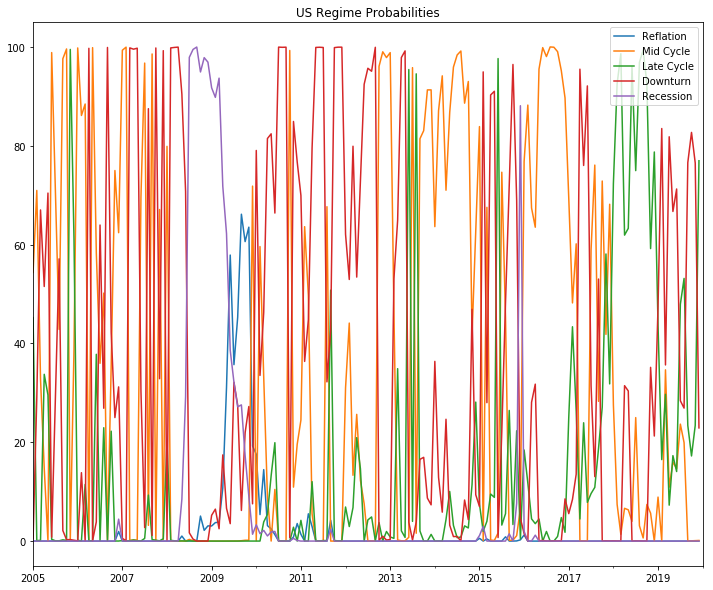

In [23]:
% matplotlib  inline


TotalProb.plot(figsize=(12,10))
plt.axis(['2005-01-01',EndDate,-5,105])
plt.title('US Regime Probabilities')